<a href="https://colab.research.google.com/github/ryantvrner/ACTL3143DQ/blob/main/DiscussionQ5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras import layers

In [5]:
from pathlib import Path

if not Path("NHTSA_NMVCCS_extract.parquet.gzip").exists():
    print("Downloading dataset")
    !wget https://github.com/JSchelldorfer/ActuarialDataScience/raw/master/

df = pd.read_parquet("NHTSA_NMVCCS_extract.parquet.gzip")
print(f"shape of DataFrame: {df.shape}")

shape of DataFrame: (6949, 16)


In [6]:
df["SUMMARY_EN"]

0       V1, a 2000 Pontiac Montana minivan, made a lef...
1       The crash occurred in the eastbound lane of a ...
2       This crash occurred just after the noon time h...
3       This single vehicle crash occurred just before...
4       The crash occurred on a two lane undivided lev...
                              ...                        
6944    The crash occurred at a three-way intersection...
6945    The crash occurred in the northbound lanes of ...
6946    The crash occurred in the eastbound lanes of a...
6947    This single-vehicle crash occurred in a rural ...
6948    This two vehicle daytime collision occurred mi...
Name: SUMMARY_EN, Length: 6949, dtype: object

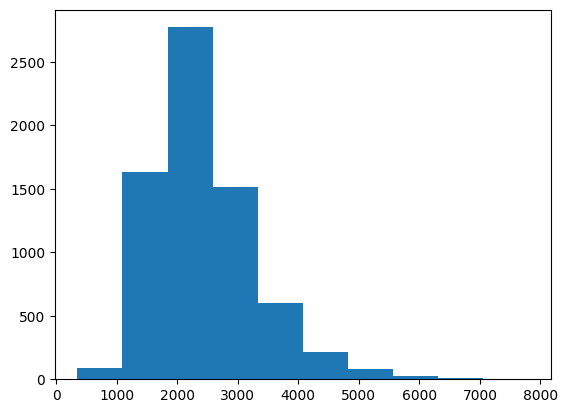

In [7]:
df["SUMMARY_EN"].map(lambda summary: len(summary)).hist(grid=False);

**BAG OF WORDS APPROACH**

In [8]:
df["INJSEVB"].value_counts()\
    .sort_index()

0    3935
1    3014
Name: INJSEVB, dtype: int64

In [26]:
from sklearn.preprocessing import LabelEncoder
target_labels = df["INJSEVB"]
target = LabelEncoder().fit_transform(target_labels)
target

array([1, 0, 0, ..., 0, 0, 0])

In [27]:
# Convert the target labels to one-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
target = onehot_encoder.fit_transform(target.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
weather_cols = [f"WEATHER{i}" for i in range(1, 9)]
features = df[["SUMMARY_EN"] + weather_cols]

X_main, X_test, y_main, y_test = \
train_test_split(features, target, test_size=0.2, random_state=1)

# As 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = \
train_test_split(X_main, y_main, test_size=0.25, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((4169, 9), (1390, 9), (1390, 9))

In [29]:
print([np.mean(y_train == y) for y in [0, 1]])

[0.5, 0.5]


In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train["SUMMARY_EN"])
vocab = list(vect.get_feature_names_out())
len(vocab)

10703

In [31]:
def vectorise_dataset(X, vect, txt_col="SUMMARY_EN", dataframe=False):
    X_vects = vect.transform(X[txt_col]).toarray()
    X_other = X.drop(txt_col, axis=1)

    if not dataframe:
        return np.concatenate([X_vects, X_other], axis=1)
    else:
# Add column names and indices to the combined dataframe.
      vocab = list(vect.get_feature_names_out())
      X_vects_df = pd.DataFrame(X_vects, columns=vocab, index=X.index)
      return pd.concat([X_vects_df, X_other], axis=1)

In [32]:
X_train_ct = vectorise_dataset(X_train, vect)
X_val_ct = vectorise_dataset(X_val, vect)
X_test_ct = vectorise_dataset(X_test, vect)

In [33]:
vectorise_dataset(X_train, vect, dataframe=True)

,00,000,000lbs,003,005,007,00am,00pm,00tydo2,01,...,zx5,zyrtec,WEATHER1,WEATHER2,WEATHER3,WEATHER4,WEATHER5,WEATHER6,WEATHER7,WEATHER8
2532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
num_features = X_train_ct.shape[1]
num_cats = 2 # -1 (no bodily harm) and 1 (bodily harm)

def build_model(num_features, num_cats):
    random.seed(42)

    model = Sequential([
        Dense(100, input_dim=num_features, activation="relu"),
        Dense(num_cats, activation="sigmoid")
    ])

    model.compile("adam", "BinaryCrossentropy",
        metrics=["accuracy"])

    return model

In [35]:
model = build_model(num_features, num_cats)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               1071200   
                                                                 
 dense_7 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,071,402
Trainable params: 1,071,402
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(patience=1, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)
%time hist = model.fit(X_train_ct, y_train, epochs=10, \
    callbacks=[es], validation_data=(X_val_ct, y_val), verbose=0);

Restoring model weights from the end of the best epoch: 5.
Epoch 6: early stopping
CPU times: user 21.9 s, sys: 811 ms, total: 22.7 s
Wall time: 15.8 s


In [37]:
model.evaluate(X_train_ct, y_train, verbose=0)

[0.019605910405516624, 0.9988006949424744]

In [38]:
model.evaluate(X_val_ct, y_val, verbose=0)

[4.415034770965576, 0.8920863270759583]

In [39]:
model.evaluate(X_test_ct, y_test, verbose=0)

[0.3321288526058197, 0.8726618885993958]

**LEMMA APPROACH**

In [40]:
vect = CountVectorizer(max_features=1_000, stop_words="english")
vect.fit(X_train["SUMMARY_EN"])
vocab = vect.get_feature_names_out()
len(vocab)

1000

In [41]:
print(vocab[:5], vocab[len(vocab)//2:(len(vocab)//2 + 5)], vocab[-5:])

['10' '105' '113' '12' '15'] ['intersection' 'interstate' 'interview' 'interviewed' 'investigating'] ['year' 'years' 'yellow' 'yield' 'zone']


In [42]:
!pip install spacy
!python -m spacy download en_core_web_sm

2023-07-03 05:18:04.528272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [45]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.text, token.pos_, token.dep_)

def lemmatize(txt):
    doc = nlp(txt)
    good_tokens = [token.lemma_.lower() for token in doc \
        if not token.like_num and \
           not token.is_punct and \
           not token.is_space and \
           not token.is_currency and \
           not token.is_stop]
    return " ".join(good_tokens)

Apple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN dobj
startup NOUN dep
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [46]:
test_str = "Incident at 100kph and '10 incidents -13.3%' are incidental?\t"
lemmatize(test_str)

'incident 100kph incident incidental'

In [47]:
df["SUMMARY_EN_LEMMA"] = df["SUMMARY_EN"].map(lemmatize)

In [48]:
weather_cols = [f"WEATHER{i}" for i in range(1, 9)]
features = df[["SUMMARY_EN_LEMMA"] + weather_cols]

X_main, X_test, y_main, y_test = \
train_test_split(features, target, test_size=0.2, random_state=1)

# As 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = \
train_test_split(X_main, y_main, test_size=0.25, random_state=1)

X_train.shape, X_val.shape, X_test.shape

((4169, 9), (1390, 9), (1390, 9))

In [49]:
vect = CountVectorizer(max_features=1_000, stop_words="english")
vect.fit(X_train["SUMMARY_EN_LEMMA"])
vocab = vect.get_feature_names_out()
len(vocab)

1000

In [50]:
print(vocab[:5], vocab[len(vocab)//2:(len(vocab)//2 + 5)], vocab[-5:])

['10' '150' '48kmph' '4x4' '56kmph'] ['level' 'lexus' 'license' 'light' 'lighting'] ['yaw' 'year' 'yellow' 'yield' 'zone']


In [51]:
X_train_ct = vectorise_dataset(X_train, vect, "SUMMARY_EN_LEMMA")
X_val_ct = vectorise_dataset(X_val, vect, "SUMMARY_EN_LEMMA")
X_test_ct = vectorise_dataset(X_test, vect, "SUMMARY_EN_LEMMA")

In [52]:
vectorise_dataset(X_train, vect, "SUMMARY_EN_LEMMA", dataframe=True)

,10,150,48kmph,4x4,56kmph,64kmph,72kmph,ability,able,accelerate,...,yield,zone,WEATHER1,WEATHER2,WEATHER3,WEATHER4,WEATHER5,WEATHER6,WEATHER7,WEATHER8
2532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2561,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6664,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6808,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
num_features = X_train_ct.shape[1]
model = build_model(num_features, num_cats)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               100900    
                                                                 
 dense_9 (Dense)             (None, 2)                 202       
                                                                 
Total params: 101,102
Trainable params: 101,102
Non-trainable params: 0
_________________________________________________________________


In [54]:
es = EarlyStopping(patience=1, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)
%time hist = model.fit(X_train_ct, y_train, epochs=10, \
    callbacks=[es], validation_data=(X_val_ct, y_val), verbose=0);

Restoring model weights from the end of the best epoch: 3.
Epoch 4: early stopping
CPU times: user 3.62 s, sys: 174 ms, total: 3.8 s
Wall time: 3.32 s


In [55]:
model.evaluate(X_train_ct, y_train, verbose=0)

[0.14918729662895203, 0.9534660577774048]

In [56]:
model.evaluate(X_val_ct, y_val, verbose=0)

[4.4649128913879395, 0.8920863270759583]

In [57]:
model.evaluate(X_test_ct, y_test, verbose=0)

[0.26919281482696533, 0.8942446112632751]

**PERMUTATION IMPORTANCE**

In [58]:
# The second model (lemmatized model) was the most accurate on the validation and test, so we will use this.

def permutation_test(model, X, y, num_reps=1, seed=42):
    """
    Run the permutation test for variable importance.
    Returns matrix of shape (X.shape[1], len(model.evaluate(X, y))).
    """
    rnd.seed(seed)
    scores = []

    for j in range(X.shape[1]):
        original_column = np.copy(X[:, j])
        col_scores = []

        for r in range(num_reps):
            rnd.shuffle(X[:,j])
            col_scores.append(model.evaluate(X, y, verbose=0))

        scores.append(np.mean(col_scores, axis=0))
        X[:,j] = original_column

    return np.array(scores)

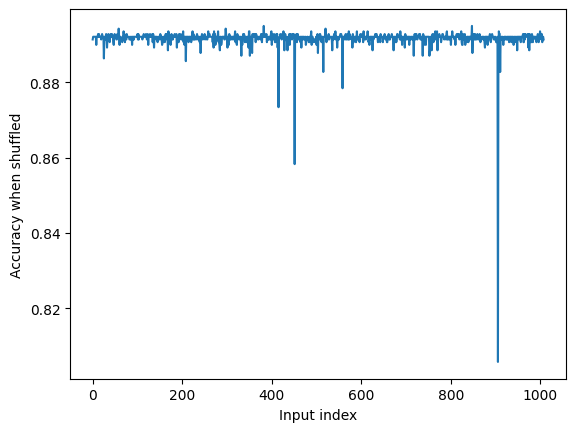

In [59]:
perm_scores = permutation_test(model, X_val_ct, y_val)[:,1]
plt.plot(perm_scores);
plt.xlabel("Input index"); plt.ylabel("Accuracy when shuffled");

In [61]:
vocab = vect.get_feature_names_out()
input_cols = list(vocab) + weather_cols

best_input_inds = np.argsort(perm_scores)[:5]
best_inputs = [input_cols[idx] for idx in best_input_inds]

print(best_inputs)

['transport', 'injury', 'hospital', 'minor', 'trauma']
